In [ ]:
"""
Toxic Comment Classification for Prompt Guardrails

This notebook fine-tunes a DistilBERT-based text classifier using the Jigsaw Toxic Comment Classification dataset.
The goal is to classify text prompts into binary labels: 'safe' and 'unsafe'.
The trained model can act as a guardrail filter before generative AI systems process prompts.

Author: Nagaraju Kuruva
Date: May 2025
Environment: Google Colab & Kaggle Notebook with GPU
Reference: https://huggingface.co/datasets/google/jigsaw_toxicity_pred & https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge
"""

In [1]:
# ==================== Imports ====================
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
from datasets import Dataset
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib_venn import venn3

In [ ]:
# ==================== Device Setup ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# ====================  Connect to Kaggle API to download data ===================
# Log into Kaggle(https://www.kaggle.com/) --> Go to Settings ---> Account --> API ---> Click on Create New Token button ---> Click on Continue --> It will download kaggale.json file
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nagarajukuruva","key":"10905af2e1b8a2b5e0394caa9a3b5478"}'}

In [4]:
# Create a directory to store API key and get API connection.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = "/root/.kaggle"

In [5]:
# Downlaod the data and unzip it.
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
!unzip jigsaw-toxic-comment-classification-challenge.zip

 95% 50.0M/52.6M [00:00<00:00, 247MB/s]
100% 52.6M/52.6M [00:00<00:00, 244MB/s]
Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           


In [2]:
# ==================== Load and Preprocess Training Data - Google Colab Platform ====================
try:
    train_data = pd.read_csv('train.csv.zip')
    print(f"Training samples: {len(train_data)}")
except Exception as e:
    raise RuntimeError("Error loading training data.") from e

Training samples: 159571


In [ ]:
# ==================== Load and Preprocess Training Data - Kaggle Platform ====================
try:
    train_data = pd.read_csv('/kaggle/input/toxicv1/train.csv')
    print(f"Training samples: {len(train_data)}")
except Exception as e:
    raise RuntimeError("Error loading training data.") from e

Training samples: 159571


In [ ]:
## Check dimensions of train data.
print(train_data.shape)

(159571, 8)


In [ ]:
## Check first record of train data.
train_data.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0


In [ ]:
## Get summary statistics of train data.
train_data.describe(include='all')

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571,159571,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
unique,159571,159571,NaN,NaN,NaN,NaN,NaN,NaN
top,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,NaN,NaN,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
## Get train data column names.
train_data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [ ]:
## Get index range for train data.
train_data.index

RangeIndex(start=0, stop=159571, step=1)

In [ ]:
## Get data types for train data columns.
train_data.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [ ]:
## Check null values for train data.
train_data.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

We **don't** have any **NA**'s in the training data.

In [ ]:
## Below method/function returns data types,levels,NA values,unique values for the given data frame.

def getStatistics(df):
    return pd.DataFrame({'dtypes' : df.dtypes,
                         'levels' : [df[column].unique() for column in df.columns],
                         'NA  Values' : df.isna().sum(),
                         'Unique Values' :  df.nunique()
                        })

In [ ]:
## Get data types,levels,NA values,unique values for train data.
getStatistics(train_data)

,dtypes,levels,NA Values,Unique Values
id,object,"[0000997932d777bf, 000103f0d9cfb60f, 000113f07...",0,159571
comment_text,object,[Explanation\nWhy the edits made under my user...,0,159571
toxic,int64,"[0, 1]",0,2
severe_toxic,int64,"[0, 1]",0,2
obscene,int64,"[0, 1]",0,2
threat,int64,"[0, 1]",0,2
insult,int64,"[0, 1]",0,2
identity_hate,int64,"[0, 1]",0,2


We **don't** have **null** values in the train data and we can see **2 levels** for label columns.

In [ ]:
## Below logic is used for checking special characters in numeric columns.

def specialCharcterVerification_NumCol(data):
    for col in data.select_dtypes(['int64','float64']).columns:
        print('\n',col,'----->')
        for index in range(1,len(data)):
            try:
                skip=float(data.loc[index,col])
                skip=int(data.loc[index,col])
            except ValueError :
                if(str(data.loc[index,col]) != 'nan'):
                    print(index,data.loc[index,col])

In [ ]:
## Check special charcters for train data numeric columns.
specialCharcterVerification_NumCol(train_data)


 toxic ----->

 severe_toxic ----->

 obscene ----->

 threat ----->

 insult ----->

 identity_hate ----->


We **don't** have any **special charcters** in label columns

In [ ]:
## calculate variance column wise.
def variance(x):
        return(pd.DataFrame({'Datatype' : x.dtypes,
                            'Variance': [round(x[i].var()) for i in x] }))

In [ ]:
## Get variance for train data numeric columns.
variance(train_data.select_dtypes(['int64','float64']))

,Datatype,Variance
toxic,int64,0
severe_toxic,int64,0
obscene,int64,0
threat,int64,0
insult,int64,0
identity_hate,int64,0


The variance for the label columns is **zero** due to the **low** proportion of **unsafe** comments in the dataset.

In [ ]:
## Check for corrlation between numeric columns of train data.
train_data[train_data.select_dtypes(['int64','float64']).columns].corr()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


We can observe a **good** **linear relationship** between the **toxic**, **obscene**, and **insult** labels.


In [ ]:
## Get missing percentage of NA values.
def missingValuesPercentage(Data):
    missing_values = (Data.isna().sum() /len(Data)).round(4) * 100
    print(missing_values.sort_values(ascending = False))

In [ ]:
## Get NA values count in percentage for train data.
missingValuesPercentage(train_data)

id               0.0
comment_text     0.0
toxic            0.0
severe_toxic     0.0
obscene          0.0
threat           0.0
insult           0.0
identity_hate    0.0
dtype: float64


We got **0%** as we don't have any **NA**'s in training data.

In [ ]:
## Drop duplicate records for train data.
train_data = train_data.drop_duplicates()

In [ ]:
##Exploratory Data Analysis ( EDA )

In [ ]:
#Univariant Analysis

<Axes: xlabel='obscene', ylabel='count'>

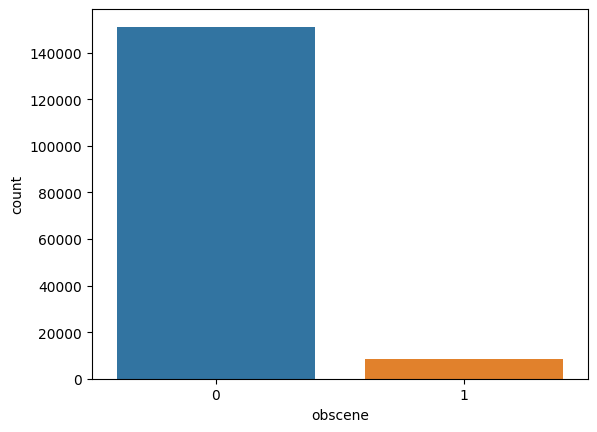

In [ ]:
# Chceck the frequency count of obscene.
sns.countplot(x='obscene',data=train_data)

We can observe that there are **very few** instances of **obscene** words in the **comments**.


In [ ]:
# Display each count level for obscene column.
train_data.obscene.value_counts()

,count
obscene,
0,151122
1,8449


<Axes: xlabel='insult', ylabel='count'>

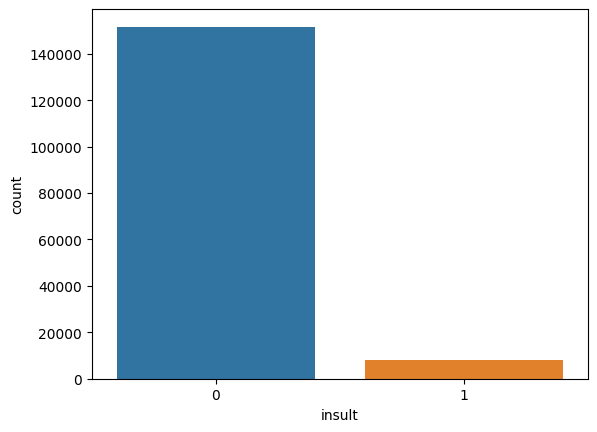

In [ ]:
# Chceck the frequency count of insult.
sns.countplot(x='insult',data=train_data)

We can observe that there are **very few** instances of **insulting** words in the **comments**.


In [ ]:
# Display each count level for insult column.
train_data.insult.value_counts()

,count
insult,
0,151694
1,7877


<Axes: xlabel='toxic', ylabel='count'>

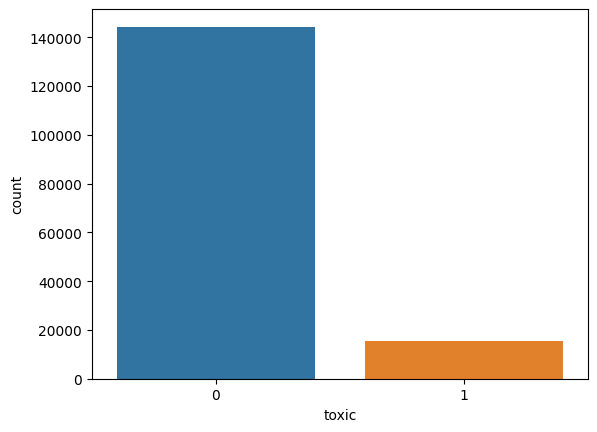

In [ ]:
# Chceck the frequency count of toxic.
sns.countplot(x='toxic',data=train_data)

We can observe that there are **very few** instances of **toxic** words in the **comments**.


In [ ]:
# Display each count level for toxic column.
train_data.toxic.value_counts()

,count
toxic,
0,144277
1,15294


<Axes: xlabel='identity_hate', ylabel='count'>

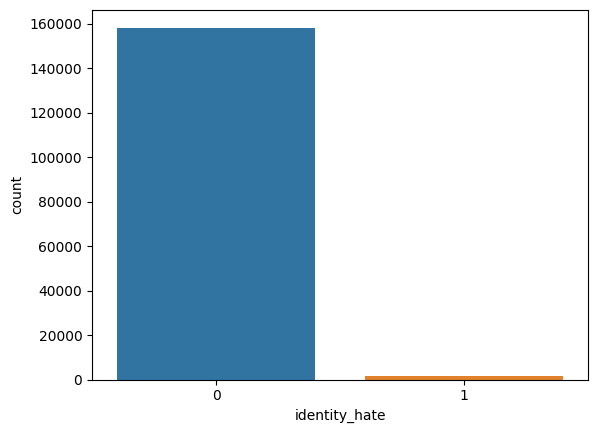

In [ ]:
# Chceck the frequency count of identity_hate.
sns.countplot(x='identity_hate',data=train_data)

We can observe that there are **very few** instances of **identity_hate** words in the **comments**.

In [ ]:
# Display each count level for identity_hate column.
train_data.identity_hate.value_counts()

,count
identity_hate,
0,158166
1,1405


<Axes: xlabel='threat', ylabel='count'>

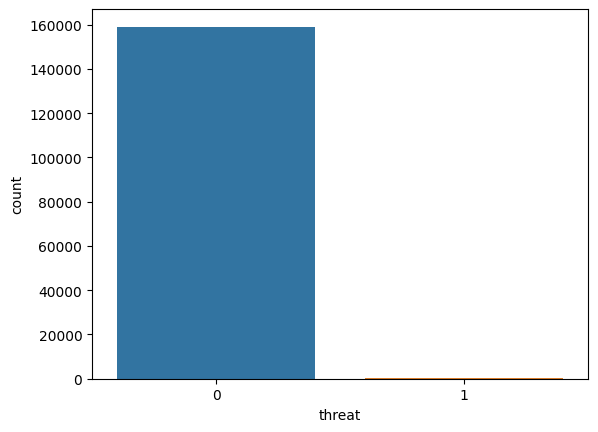

In [ ]:
# Chceck the frequency count of threat.
sns.countplot(x='threat',data=train_data)

We can observe that there are **very few** instances of **threat** words in the **comments**.

In [ ]:
# Display each count level for threat column.
train_data.threat.value_counts()

,count
threat,
0,159093
1,478


In [ ]:
# Check the toxic percentage.
import plotly.express as px
fig = px.pie(
    train_data.toxic,
    values=train_data.toxic.value_counts().values,
    names=["nontoxic", "toxic"],
    width=500,
    height=500
)
fig.update_layout(
    showlegend=False,
    title="Toxic Rate"
)
fig.update_traces(textinfo='label+percent')
fig.show()

We can observe that there are **very few** instances of **toxic** words in the **comments**.

In [ ]:
# Check the severe_toxic percentage.
import plotly.express as px
fig = px.pie(
    train_data.severe_toxic,
    values=train_data.severe_toxic.value_counts().values,
    names=["nonsevere_toxic", "severe_toxic"],
    width=500,
    height=500
)
fig.update_layout(
    showlegend=False,
    title="Severe toxic Rate"
)
fig.update_traces(textinfo='label+percent')
fig.show()

We can observe that there are **very few** instances of **severe_toxic** words in the **comments**.

In [ ]:
# Check the obscene percentage.
import plotly.express as px
fig = px.pie(
    train_data.obscene,
    values=train_data.obscene.value_counts().values,
    names=["nonobscene", "obscene"],
    width=500,
    height=500
)
fig.update_layout(
    showlegend=False,
    title="Obscene Rate"
)
fig.update_traces(textinfo='label+percent')
fig.show()

We can observe that there are **very few** instances of **obscene** words in the **comments**.

In [ ]:
# Check the threat percentage.
import plotly.express as px
fig = px.pie(
    train_data.threat,
    values=train_data.threat.value_counts().values,
    names=["nonthreat", "threat"],
    width=500,
    height=500
)
fig.update_layout(
    showlegend=False,
    title="Threat Rate"
)
fig.update_traces(textinfo='label+percent')
fig.show()

We can observe that there are **very few** instances of **threat** words in the **comments**.

In [ ]:
# Check the insult percentage.
import plotly.express as px
fig = px.pie(
    train_data.insult,
    values=train_data.insult.value_counts().values,
    names=["noninsult", "insult"],
    width=500,
    height=500
)
fig.update_layout(
    showlegend=False,
    title="Insult Rate"
)
fig.update_traces(textinfo='label+percent')
fig.show()

We can observe that there are **very few** instances of **insult** words in the **comments**.

In [ ]:
# Check the identity_hate percentage.
import plotly.express as px
fig = px.pie(
    train_data.identity_hate,
    values=train_data.identity_hate.value_counts().values,
    names=["nonidentity_hate", "identity_hate"],
    width=500,
    height=500
)
fig.update_layout(
    showlegend=False,
    title="Identity hate Rate"
)
fig.update_traces(textinfo='label+percent')
fig.show()

We can observe that there are **very few** instances of **identity_hate** words in the **comments**.

In [ ]:
# Let's look at the character length for the rows in the training data.
train_data['char_length'] = train_data['comment_text'].apply(lambda x: len(str(x)))

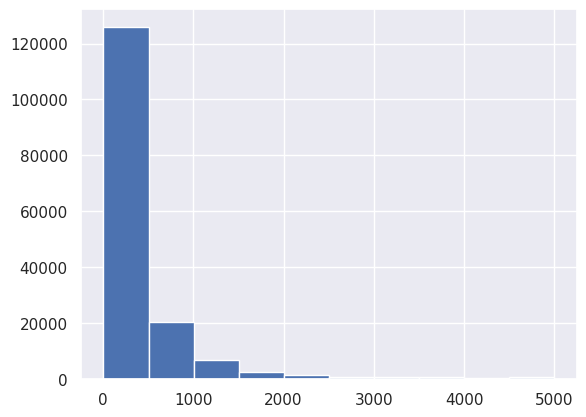

In [ ]:
# look at the histogram plot for text length.
sns.set()
train_data['char_length'].hist()
plt.show()

We can observe that the majority of **comments** have a **length** ranging from **10 to 500** words.


In [ ]:
# Check multi colinearity between numeric varibles for train data.
train_data.select_dtypes(['int64','float64']).corr()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,char_length
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009,-0.054470
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600,0.010131
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867,-0.042945
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128,-0.008011
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736,-0.045052
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000,-0.013647
char_length,-0.054470,0.010131,-0.042945,-0.008011,-0.045052,-0.013647,1.000000


<Axes: title={'center': 'Correlation of features & targets'}>

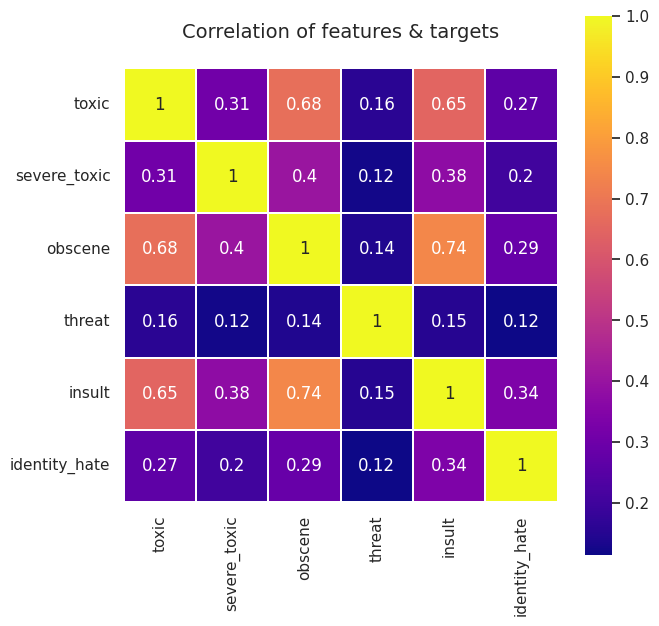

In [ ]:
# Check the multi colinearity plot.
data = train_data[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

The **correlation matrix** shows interesting things :

**toxic** is clearly correlated with **obscene** and **insult** (0.68 and 0.65)

**toxic** and **severe_toxic** are only got a 0.31 correlation factor

**insult** and **obscene** have a correlation factor of 0.74

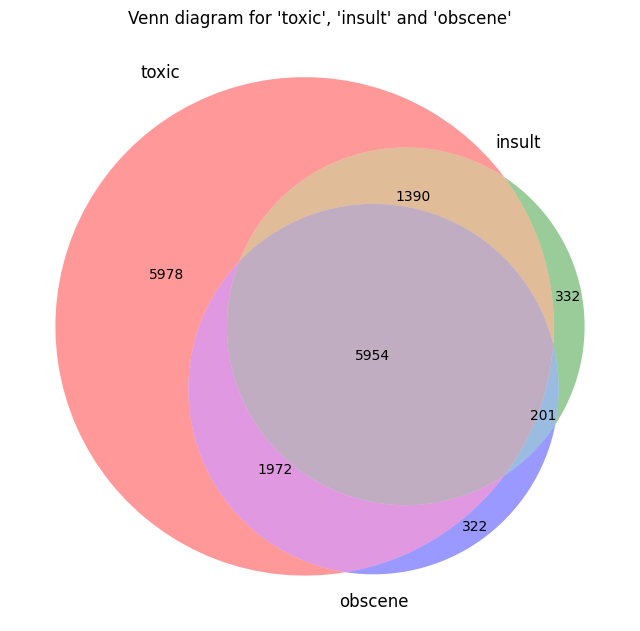

In [ ]:
t = train_data[(train_data['toxic'] == 1) & (train_data['insult'] == 0) & (train_data['obscene'] == 0)].shape[0]
i = train_data[(train_data['toxic'] == 0) & (train_data['insult'] == 1) & (train_data['obscene'] == 0)].shape[0]
o = train_data[(train_data['toxic'] == 0) & (train_data['insult'] == 0) & (train_data['obscene'] == 1)].shape[0]

t_i = train_data[(train_data['toxic'] == 1) & (train_data['insult'] == 1) & (train_data['obscene'] == 0)].shape[0]
t_o = train_data[(train_data['toxic'] == 1) & (train_data['insult'] == 0) & (train_data['obscene'] == 1)].shape[0]
i_o = train_data[(train_data['toxic'] == 0) & (train_data['insult'] == 1) & (train_data['obscene'] == 1)].shape[0]

t_i_o = train_data[(train_data['toxic'] == 1) & (train_data['insult'] == 1) & (train_data['obscene'] == 1)].shape[0]


# Make the diagram
plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic', 'insult' and 'obscene'")
venn3(subsets = (t, i, t_i, o, t_o, i_o, t_i_o),
      set_labels=('toxic', 'insult', 'obscene'))
plt.show()

This venn diagram demonstrates the correlations found in the previous visualization.

There is only a small part of **insult** and **obscene** that are not also labelled **toxic**.

**5954** comments are labelled with all **3** categories.

In [ ]:
# Flag safe and unsafe comments.
train_data['safe_unsafe'] = train_data.apply(
    lambda row: 'unsafe' if (
        row['toxic'] ==1 or
        row['severe_toxic'] ==1 or
        row['obscene'] ==1 or
        row['threat'] ==1 or
        row['insult'] ==1 or
        row['identity_hate'] ==1
    ) else 'safe',
    axis=1
)

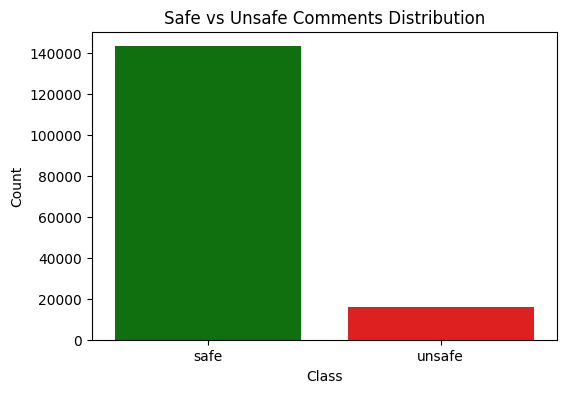

In [ ]:
# Check the frquency of safe and unsafe comments.
plt.figure(figsize=(6,4))
sns.countplot(x='safe_unsafe',data=train_data, palette=['green', 'red'])
plt.title("Safe vs Unsafe Comments Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

We can observe that the **majority** of the **comments** are labeled as **safe**.

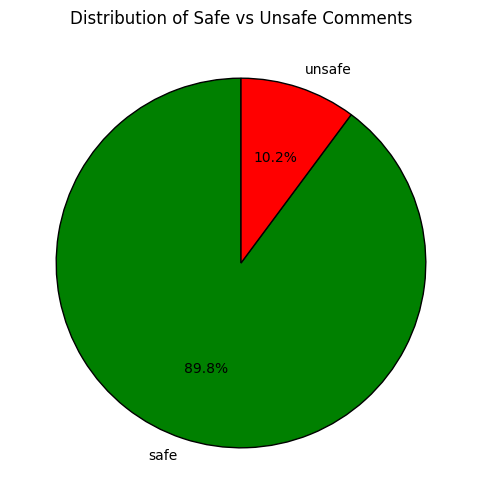

In [ ]:
# Calculate counts of safe and unsafe
counts = train_data['safe_unsafe'].value_counts()

# Plot pie chart with percentages
plt.figure(figsize=(6, 6))
plt.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',  # show percentages with 1 decimal
    startangle=90,
    colors=['green', 'red'],  # optional colors
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Distribution of Safe vs Unsafe Comments')
plt.show()

We can observe that the **majority** of the **comments** are labeled as **safe**.

In [ ]:
# Check the frquency of safe and unsafe comments.
train_data['safe_unsafe'].value_counts()

,count
safe_unsafe,
safe,143346
unsafe,16225


In [ ]:
# Let's check unsafe comments frequnecy with respect to labels.
df_distribution = train_data[train_data['safe_unsafe']=='unsafe'][['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

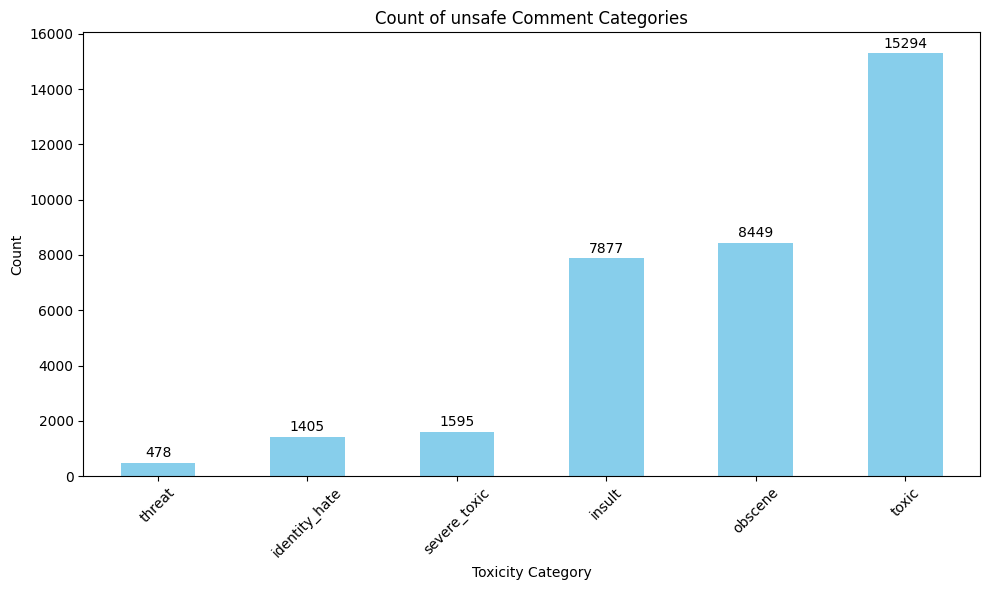

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
ax = df_distribution['count'].plot(kind='bar', color='skyblue')

plt.xlabel('Toxicity Category')
plt.ylabel('Count')
plt.title('Count of unsafe Comment Categories')
plt.xticks(rotation=45)

# Add value labels on top of bars
for idx, value in enumerate(df_distribution['count']):
    plt.text(idx, value + 100, str(value), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

The **distribution** indicates a higher prevalence of **toxicity**-related comments compared to **other classes**.



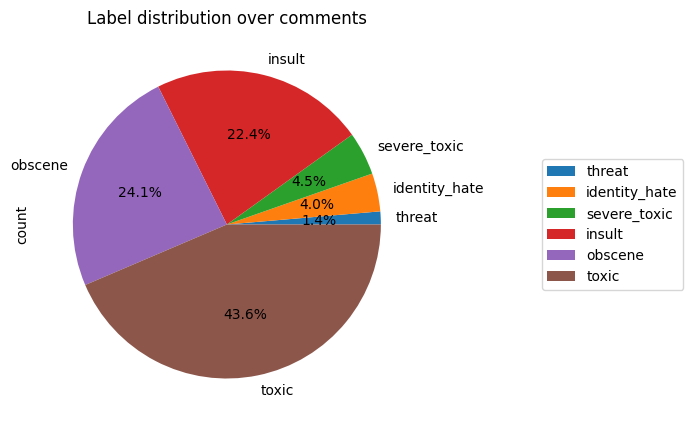

In [ ]:
df_distribution.plot.pie(y='count',title='Label distribution over comments',figsize=(5, 5), autopct='%1.1f%%').legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

The **distribution** indicates a higher prevalence of **toxicity**-related comments compared to **other classes**.

In [ ]:
# Display the frequency of each label.
df_distribution.sort_values('count', ascending=False)

,count
toxic,15294
obscene,8449
insult,7877
severe_toxic,1595
identity_hate,1405
threat,478


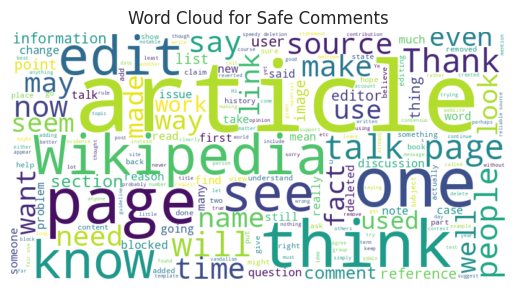

In [ ]:
# Plot the word cloud of safe comments.
comments = ' '.join(train_data[train_data['safe_unsafe']=='safe']['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Safe Comments')
plt.show()

We can observe from the safe comments word cloud that terms like **article**, **wikipedia**, **page**, **think**, and **edit** are among the most frequently occurring words in the comments.

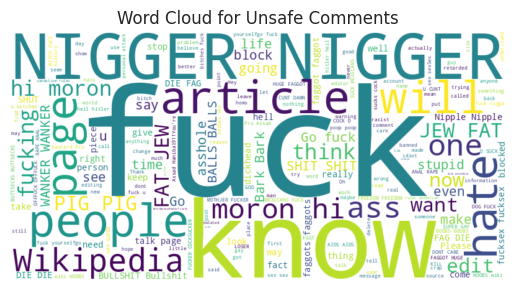

In [ ]:
# Plot the word cloud of unsafe comments.
comments = ' '.join(train_data[train_data['safe_unsafe']=='unsafe']['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Unsafe Comments')
plt.show()

We can observe from the unsafe comments word cloud that terms like **fuck**, **nigger**, **fucking**, **hate**, and **fat** are among the most frequently occurring words in the comments.

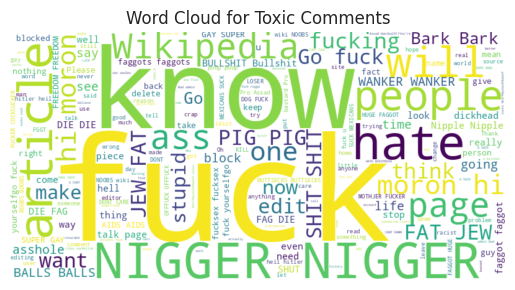

In [ ]:
# Plot the word cloud of toxic comments.
comments = ' '.join(train_data[train_data['toxic']==1]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Toxic Comments')
plt.show()

We can observe from the toxic comments word cloud that terms like **fuck**, **nigger**, **ass**, **hate**, and **fat** are among the most frequently occurring words in the comments.

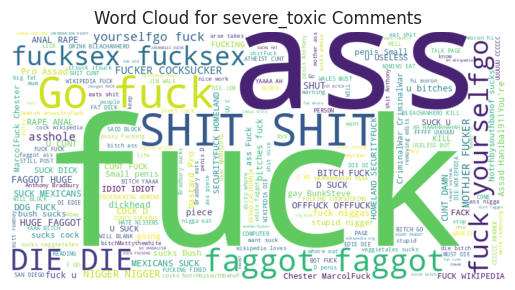

In [ ]:
# Plot the word cloud of severe_toxic comments.
comments = ' '.join(train_data[train_data['severe_toxic']==1]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for severe_toxic Comments')
plt.show()

We can observe from the severe_toxic comments word cloud that terms like **fuck**, **shit**, **ass**, **die**, and **faggot** are among the most frequently occurring words in the comments.

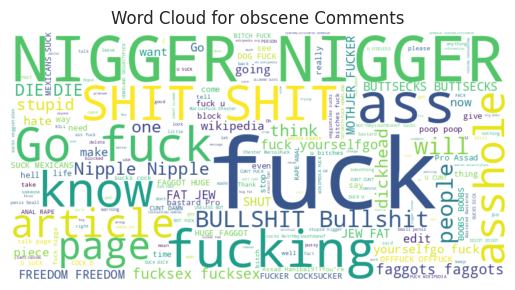

In [ ]:
# Plot the word cloud of obscene comments.
comments = ' '.join(train_data[train_data['obscene']==1]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for obscene Comments')
plt.show()

We can observe from the obscene comments word cloud that terms like **fuck**, **bullshit**, **ass**, **nigger**, **asshole** and **nipple** are among the most frequently occurring words in the comments.

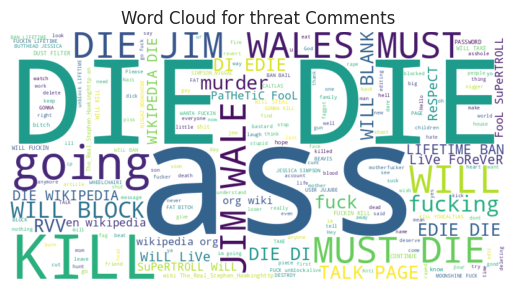

In [ ]:
# Plot the word cloud of threat comments.
comments = ' '.join(train_data[train_data['threat']==1]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for threat Comments')
plt.show()

We can observe from the threat comments word cloud that terms like **Die**, **Ass**, **Kill**, and **Murder** are among the most frequently occurring words in the comments.

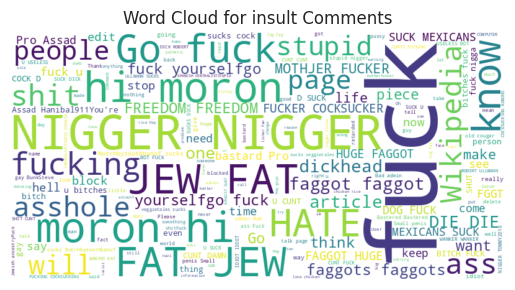

In [ ]:
# Plot the word cloud of insult comments.
comments = ' '.join(train_data[train_data['insult']==1]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for insult Comments')
plt.show()

We can observe from the insult comments word cloud that terms like **Fuck**, **Jew**, **Fat**, **Moron**, **Stupid** and **Nigger** are among the most frequently occurring words in the comments.

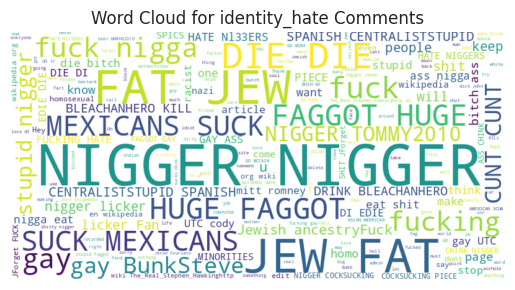

In [ ]:
# Plot the word cloud of identity_hate comments.
comments = ' '.join(train_data[train_data['identity_hate']==1]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for identity_hate Comments')
plt.show()

We can observe from the identity_hate comments word cloud that terms like **Nigger**, **Suck**, **Fat**, **Gay**, **Die** and **Faggot** are among the most frequently occurring words in the comments.

In [ ]:
# Check the top 5 records from training data.
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,char_length,safe_unsafe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,safe
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,safe
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,safe
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,safe
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,safe


In [3]:
# Map 6 multi-labels to binary label
toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_data['label'] = train_data[toxic_labels].max(axis=1).apply(lambda x: 1 if x >= 0.5 else 0)  # 1=unsafe, 0=safe
train_data = train_data[['comment_text', 'label']].dropna()

# Split for initial train/test (before Sampling).
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_data['comment_text'].tolist(), train_data['label'].tolist(), test_size=0.2, random_state=474, stratify=train_data['label'])


In [6]:
#!pip install numpy==1.26.4 --no-cache-dir
#!pip install evaluate

In [8]:
# Tokenizer for vectorizing text before Sampling.
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [9]:
# Convert text to embeddings for Sampling (using mean pooled token IDs as proxy for real embedding)
def get_vector(text):
    tokens = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="np")
    return tokens['input_ids'].mean(axis=1)[0]  # crude representation

In [10]:
# Convert the tokens into an array for sampling.
X_embed = np.array([get_vector(text) for text in train_texts])
y_embed = np.array(train_labels)

In [11]:
# Convert 2D to 1D.
X_embed = X_embed.reshape(-1, 1)

In [12]:
# Perform Sampling as we have less unsafe coments.
ros = RandomOverSampler(random_state=474)
X_resampled, y_resampled = ros.fit_resample(X_embed, y_embed)
train_texts_balanced = [train_texts[i] for i in ros.sample_indices_]
train_labels_balanced = list(y_resampled)

In [13]:
# Convert to HuggingFace Dataset.
train_dataset = Dataset.from_dict({'text': train_texts_balanced, 'label': train_labels_balanced})
val_dataset = Dataset.from_dict({'text': val_texts, 'label': val_labels})

In [14]:
# Tokenize datasets.
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

In [15]:
# map the train and validation tokens data.
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/229352 [00:00<?, ? examples/s]

Map:   0%|          | 0/31915 [00:00<?, ? examples/s]

In [16]:
# Load distilbert model.
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

In [18]:
# Compute metrics.
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision.compute(predictions=preds, references=labels)["precision"],
        "recall": recall.compute(predictions=preds, references=labels)["recall"],
        "f1": f1.compute(predictions=preds, references=labels)["f1"],
    }

In [19]:
# Training Arguments.
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    save_strategy="no",
    logging_dir="./logs",
    logging_steps=10,
    report_to=[]
)

In [20]:
# Trainer.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [22]:
# Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.059600,0.175819,0.964781,0.796809,0.877350,0.835142


TrainOutput(global_step=14335, training_loss=0.10949217172038754, metrics={'train_runtime': 2720.1633, 'train_samples_per_second': 84.316, 'train_steps_per_second': 5.27, 'total_flos': 7595415704137728.0, 'train_loss': 0.10949217172038754, 'epoch': 1.0})

In [23]:
# Evaluate
results = trainer.evaluate()
print("\n📊 Evaluation Metrics:")
print(results)


📊 Evaluation Metrics:
{'eval_loss': 0.17581915855407715, 'eval_accuracy': 0.9647814507284975, 'eval_precision': 0.7968094038623006, 'eval_recall': 0.8773497688751926, 'eval_f1': 0.8351422704605456, 'eval_runtime': 121.5205, 'eval_samples_per_second': 262.631, 'eval_steps_per_second': 16.417, 'epoch': 1.0}


We observe that the **loss** is relatively **low**, and the evaluation metrics—including **accuracy**, **precision**, **recall**, and **F1** score—indicate **strong** model **performance**.


In [25]:
# Predictions
predictions = trainer.predict(tokenized_val)
y_true = predictions.label_ids
y_probs = predictions.predictions
y_pred = np.argmax(y_probs, axis=1)

In [26]:
# Save model in .pt format (PyTorch state_dict)
torch.save(model.state_dict(), "fine_tuned_prompt_guardrails_model.pt")
print("✅ Model saved as fine_tuned_prompt_guardrails_model.pt")


✅ Model saved as fine_tuned_prompt_guardrails_model.pt


In [27]:
# Classification Report
print("\n🔍 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["safe", "unsafe"]))


🔍 Classification Report:
              precision    recall  f1-score   support

        safe       0.99      0.97      0.98     28670
      unsafe       0.80      0.88      0.84      3245

    accuracy                           0.96     31915
   macro avg       0.89      0.93      0.91     31915
weighted avg       0.97      0.96      0.97     31915



We observe that the evaluation metrics—including **accuracy**, **precision**, **recall**, and **F1** score—indicate **strong** model **performance**.


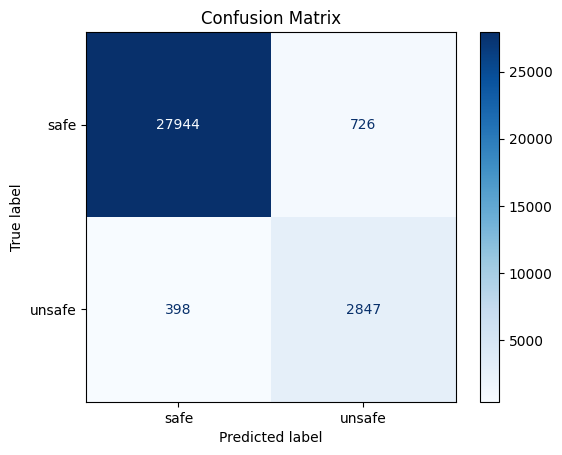

In [28]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["safe", "unsafe"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

It appears that the number of **incorrect** predictions is quite **minimal**, which is encouraging.


📈 ROC AUC Score (unsafe class): 0.9831


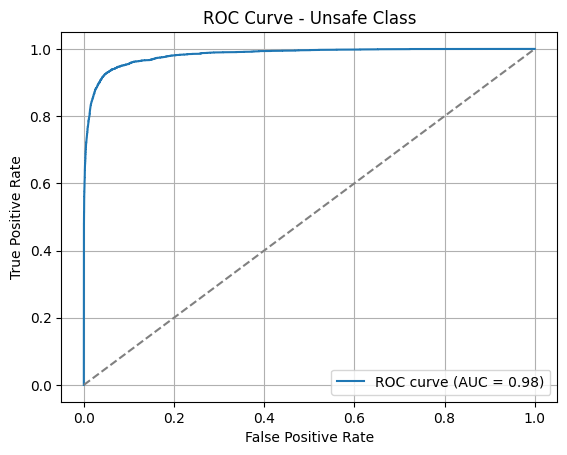

In [29]:
# ROC-AUC
probs_unsafe = y_probs[:, 1]
fpr, tpr, _ = roc_curve(y_true, probs_unsafe)
roc_auc = roc_auc_score(y_true, probs_unsafe)
print(f"\n📈 ROC AUC Score (unsafe class): {roc_auc:.4f}")

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Unsafe Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

The area under the curve is nearly **100%**, which is excellent and suggests that the model is performing **exceptionally** well.


🧪 Precision-Recall AUC: 0.9221


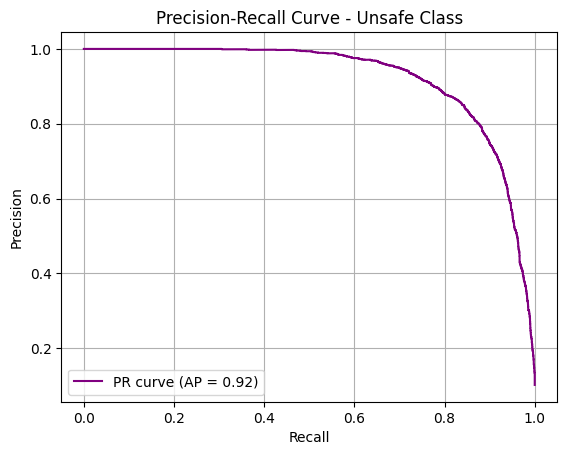

In [30]:
# Precision-Recall
precision_vals, recall_vals, _ = precision_recall_curve(y_true, probs_unsafe)
pr_auc = average_precision_score(y_true, probs_unsafe)
print(f"\n🧪 Precision-Recall AUC: {pr_auc:.4f}")

plt.plot(recall_vals, precision_vals, label=f"PR curve (AP = {pr_auc:.2f})", color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Unsafe Class")
plt.grid(True)
plt.legend()
plt.show()

In [32]:
# ==================== Load and Preprocess Test Data - Google Colab Platform ====================
try:
    test_df = pd.read_csv('test.csv.zip')
except Exception as e:
    raise RuntimeError("Test data not found.") from e

# Clean test comments
test_df['comment_text'] = test_df['comment_text'].str.lower()
test_df['comment_text'] = test_df['comment_text'].str.replace("\xa0", " ", regex=False).str.split().str.join(" ")
test_texts = test_df["comment_text"].tolist()

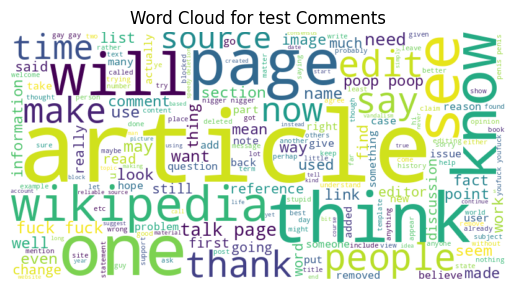

In [39]:
# Plot the word cloud for test comments.
comments = ' '.join(test_df['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for test Comments')
plt.show()

We can observe from the  test comments word cloud that terms like **article**, **wikipedia**, **page**, **think**, and **one** are among the most frequently occurring words in the comments.

In [34]:
# Tokenize test data.
test_dataset = Dataset.from_pandas(test_df[["comment_text"]].rename(columns={"comment_text": "text"}))
tokenized_test = test_dataset.map(tokenize_function, batched=True)
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask"])

Map:   0%|          | 0/153164 [00:00<?, ? examples/s]

In [35]:
#  Get Predictions for test data.
test_outputs = trainer.predict(tokenized_test)
test_logits = test_outputs.predictions
test_preds = np.argmax(test_logits, axis=1)

In [36]:
# Map predictions to labels.
label_map = {0: "safe", 1: "unsafe"}
predicted_labels = [label_map[p] for p in test_preds]

In [37]:
# Save to new CSV
test_df["prediction"] = predicted_labels
test_df.to_csv("test_predictions.csv", index=False)

print("✅ Predictions saved to 'test_predictions.csv'")

✅ Predictions saved to 'test_predictions.csv'


In [38]:
# Check first 5 records of test data.
test_df.head()

,id,comment_text,prediction
0,00001cee341fdb12,yo bitch ja rule is more succesful then you'll...,unsafe
1,0000247867823ef7,"== from rfc == the title is fine as it is, imo.",safe
2,00013b17ad220c46,""" == sources == * zawe ashton on lapland — / """,safe
3,00017563c3f7919a,":if you have a look back at the source, the in...",safe
4,00017695ad8997eb,i don't anonymously edit articles at all.,safe


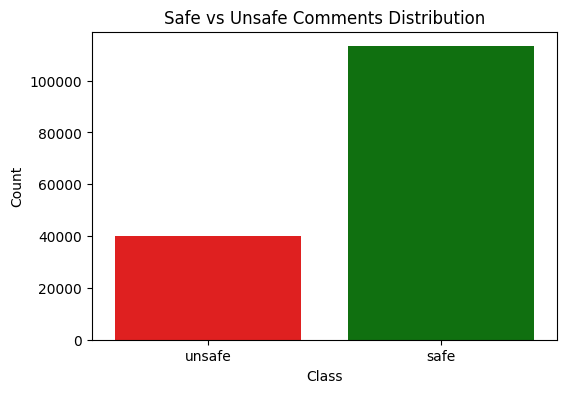

In [40]:
# Check the frquency of safe and unsafe comments.
plt.figure(figsize=(6,4))
sns.countplot(x='prediction',data=test_df, palette=['red','green'])
plt.title("Safe vs Unsafe Comments Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

It appears that the **test** set also contains a **majority** of **safe** comments.

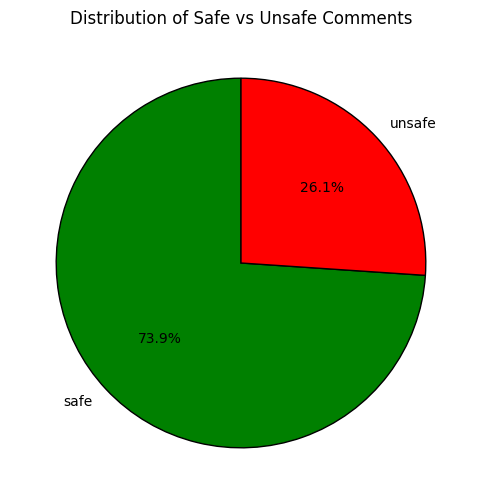

In [41]:
# Calculate counts of safe and unsafe.
counts = test_df['prediction'].value_counts()

# Plot pie chart with percentages.
plt.figure(figsize=(6, 6))
plt.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',  # show percentages with 1 decimal
    startangle=90,
    colors=['green', 'red'],  # optional colors
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Distribution of Safe vs Unsafe Comments')
plt.show()

It appears that the **test** set also contains a **majority** of **safe** comments.

In [44]:
# Check the value count of safe and unsafe comments.
test_df.prediction.value_counts()

,count
prediction,
safe,113241
unsafe,39923


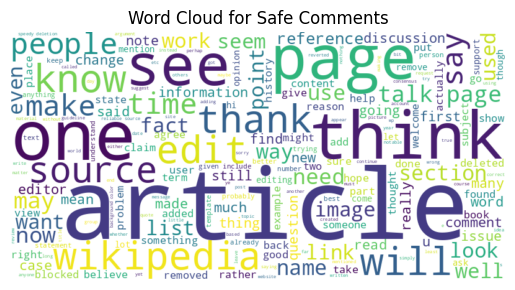

In [42]:
# Plot the word cloud of safe comments.
comments = ' '.join(test_df[test_df['prediction']=='safe']['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Safe Comments')
plt.show()

We can observe from the safe comments word cloud that terms like **article**, **wikipedia**, **page**, **think**, and **one** are among the most frequently occurring words in the comments.

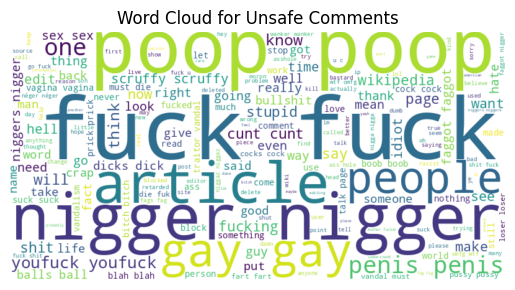

In [43]:
# Plot the word cloud of unsafe comments.
comments = ' '.join(test_df[test_df['prediction']=='unsafe']['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Unsafe Comments')
plt.show()

We can observe from the unsafe comments word cloud that terms like **fuck**, **nigger**, **gay**, **poop**, and **penis** are among the most frequently occurring words in the comments.